## v1.3: FNN Classification | 1 row as input | Over sampling methods

### Importing Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 110)
import numpy as np
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, quantile_transform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder
%matplotlib inline

### Processing train.csv Dataset

In [2]:
df = pd.read_csv("train_data.csv")

# Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)

# Filtering events with len=1 or min_tca > 2 or max_tca < 2
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].min()<2.0)
df = df.groupby('event_id').filter(lambda x : x["time_to_tca"].max()>2.0)

# OHE for c_object_type (5 categories) -> 5 new features
df = pd.get_dummies(df)

# Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df = encoder.fit_transform(df)

df

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
9,2,6.983474,0,0,0,0,1,-10.816161,-6.601713,13.293159,22902.0,14348.0,-1157.6,-6306.2,21986.3,15.8,-13792.0,-3957.1,1.0,0.0,3.92,3.92,444,442,99.4,1.094,3.4505,0.025520,0.009390,0.000019,7158.394530,0.000860,98.523094,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.396928,0.001367,69.717278,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,12.0,2.0,786.417082,774.097978,800.056782,780.463075,63.955771,-16.008858,-0.063092,115.208802,4.110620e+06,2.715773e+18,9.039007,257.208281,147.615141,38173.433170,1.642649,218.243786,0.153332,39.695541,0.009370,0.269965,0.003886,0.339406,73.0,77.0,27.0,4.0,0,0,0,0,1
10,2,6.691611,0,0,0,0,1,-10.850473,-6.603452,13.374242,22966.0,14348.0,-1161.1,-6330.2,22046.3,15.8,-13792.0,-3957.1,1.0,0.0,3.86,3.86,444,442,99.4,1.099,3.4505,0.024168,0.010812,0.000017,7158.394561,0.000861,98.523097,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,180.0,2.0,13.87,13.87,15.0,15.0,100.0,1.838,0.814291,0.564380,0.000726,7168.397641,0.001367,69.717278,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,12.0,2.0,786.420510,774.094612,800.057080,780.464203,63.956674,-16.008858,-0.063092,101.429474,1.158624e+07,2.704770e+18,8.994890,257.185050,242.290796,38098.346421,1.675557,218.238631,0.252043,39.617319,0.009373,0.269926,0.003939,0.339393,73.0,77.0,27.0,4.0,0,0,0,0,1
11,2,6.269979,0,0,0,0,1,-30.000000,-6.217958,426.808532,18785.0,14347.0,-698.8,-5176.4,18044.8,14.4,-13791.4,-3957.2,1.0,0.0,3.85,3.85,447,445,99.4,1.113,3.4505,0.023038,0.009797,0.000016,7158.407962,0.000862,98.523100,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,1.0,0.0,14.63,14.63,15.0,15.0,100.0,1.641,0.849987,0.476139,0.000712,7168.395887,0.001297,69.718437,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,12.0,2.0,786.439755,774.102169,799.554662,780.963112,63.903391,-16.009902,-0.057504,177.272242,3.780413e+06,7.644201e+13,9.927960,48.396653,121.934573,2521.604251,1.824402,86.921700,0.126831,2.616

### Which is the lenght of the sequences of high risk?

In [3]:
df_prueba = pd.DataFrame.copy(df)
df_prueba["event-lenght"] = df_prueba.groupby('event_id')['event_id'].transform('value_counts')
df_prueba = df_prueba.groupby(["event_id"]).apply(lambda x: x.iloc[-1])
df_prueba = df_prueba[df_prueba["risk"]>=-6]
df_prueba

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN,event-lenght
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
168,168.0,0.167720,0.0,0.0,0.0,0.0,1.0,-5.019997,-5.014888,0.860278,3176.0,11029.0,-66.3,2149.5,-2337.5,78.8,-8116.4,-7467.5,1.0,0.0,3.56,3.56,510.0,508.0,98.9,1.031,3.4500,0.023972,0.015037,2.095400e-05,7157.025125,0.000715,98.620519,0.083989,0.125591,0.016693,-0.157717,-0.913714,0.045804,-0.999868,-0.098836,-0.124526,0.172464,0.051114,0.068591,-0.379399,-0.088191,-0.053355,180.0,2.0,17.81,17.81,21.0,21.0,98.8,2.236,0.862058,0.367120,0.000479,7227.737769,0.013893,71.046891,0.963400,0.131466,-0.056714,-0.962820,-0.999990,0.060564,-0.088206,0.181982,-0.703845,-0.184149,0.048145,-0.198561,0.842787,0.201401,-0.917805,12.00,2.00,784.007014,773.769236,950.018356,749.183182,69.632063,-42.615631,-0.409359,90.605206,1.925691e+02,1.693518e+15,2.002837,234.736512,5.792260,25524.233583,1.210034,35.710237,0.006384,26.439907,0.002079,0.067457,0.002793,0.323809,70.0,76.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,21.0
197,197.0,0.100123,0.0,0.0,0.0,0.0,1.0,-5.423774,-5.389659,1.455639,3492.0,9028.0,-485.6,-2744.9,-2104.3,38.4,-5498.0,7161.8,1.0,0.0,3.50,3.50,526.0,524.0,99.3,1.096,3.4510,0.014801,0.010753,1.417730e-05,7155.568041,0.002776,98.563629,-0.093296,0.255365,0.051183,0.105177,-0.988395,-0.048399,-0.999871,0.087358,-0.256213,-0.097326,0.079960,-0.044801,0.328006,0.036174,-0.079843,180.0,2.0,99.00,70.02,15.0,9.0,100.0,0.719,0.547375,0.178779,0.000625,7113.551172,0.009877,98.809217,0.135635,-0.383363,-0.076408,-0.119340,-0.999692,0.054266,-0.997833,-0.070225,0.380894,0.053845,0.794298,0.037431,0.170623,-0.034697,-0.797409,12.00,2.00,797.295942,757.566140,805.675728,665.152616,-79.076386,52.487124,-0.243681,58.491982,1.084490e+03,4.018069e+15,1.976865,301.300780,12.818682,6382.682038,1.354118,36.033706,0.010862,6.624182,0.002049,0.310974,0.002891,0.709326,82.0,77.0,40.0,17.0,1.0,0.0,0.0,0.0,0.0,15.0
225,225.0,0.077000,0.0,1.0,0.0,0.0,0.0,-5.432268,-4.641494,4.266507,3372.0,8576.0,-0.8,-2750.9,1951.2,71.9,-4962.4,-6994.9,1.0,0.0,3.50,3.50,3268.0,3265.0,99.3,0.942,4.7959,0.019765,0.017720,2.322240e-05,7169.215161,0.000513,98.644317,0.152761,0.268842,0.095466,-0.080199,-0.871233,0.026701,-0.999911,-0.163519,-0.269073,0.090534,0.084512,0.028985,0.337516,-0.021771,-0.085650,180.0,2.0,26.01,26.01,36.0,36.0,100.0,1.613,0.070343,0.023740,0.000160,7116.659551,0.012348,99.286526,0.472000,0.429305,-0.001524,-0.474763,-0.999945,0.000241,-0.774318,0.192339,-0.477274,-0.189298,0.557785,-0.002048,0.808969,-0.000762,-0.

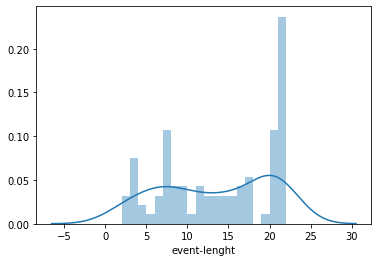

In [4]:
# Distribution of the event leghts of the events with high risk
sns.distplot(df_prueba["event-lenght"],bins=20)

In [5]:
ids_high_risk = np.array(df_prueba["event_id"])
ids_high_risk

array([  168.,   197.,   225.,   294.,   424.,   461.,   559.,  1408.,
        1414.,  1429.,  1545.,  1741.,  1855.,  1936.,  2115.,  2198.,
        2406.,  2548.,  2563.,  2942.,  2958.,  3439.,  3590.,  3615.,
        4104.,  4284.,  4351.,  4720.,  4942.,  5253.,  5343.,  5348.,
        5462.,  5773.,  5863.,  6341.,  6552.,  6578.,  6705.,  6723.,
        6792.,  6836.,  6980.,  7126.,  7427.,  7629.,  7678.,  7717.,
        7797.,  7888.,  7912.,  8449.,  8550.,  8561.,  8583.,  8591.,
        8661.,  8664.,  8758.,  8767.,  8776.,  8851.,  8887.,  8972.,
        9051.,  9383.,  9411.,  9556.,  9657.,  9851., 10184., 10510.,
       10778., 10787., 10849., 10982., 11033., 11072., 11146., 11180.,
       11530., 11597., 11692., 11795., 11851., 11876., 11953., 12175.,
       12226., 12726., 12766., 12769., 12992.])

In [6]:
df_high_risk = df.loc[df["event_id"].isin(ids_high_risk)]
df_high_risk

,event_id,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN
2122,168,6.756629,0,0,0,0,1,-5.015788,-5.007446,0.817600,5824.0,11029.0,-50.9,3940.9,-4288.0,77.0,-8116.4,-7467.5,1.0,0.0,3.65,3.65,512,506,99.4,1.080,3.4610,0.018468,0.011431,0.000020,7157.028634,0.000716,98.620518,0.066656,0.579201,0.058749,-0.061214,-0.999777,-0.053069,-0.999335,-0.102965,-0.579432,0.097538,0.198440,0.016519,-0.176517,-0.016124,-0.198472,180.0,2.0,17.81,17.81,21.0,21.0,98.8,2.236,0.862058,0.367120,0.000479,7227.732232,0.013893,71.046887,0.965280,0.128729,-0.054827,-0.964730,-0.999991,0.058574,-0.079415,0.183673,-0.704493,-0.185782,0.040275,-0.199956,0.842999,0.202719,-0.917987,12.00,2.0,784.014704,773.768564,950.012673,749.177792,69.617872,-42.615631,-0.400008,34.530214,9.164779e+05,1.790548e+15,7.397519,240.975102,123.685569,26220.816158,1.286767,35.780484,0.128575,27.161381,0.007711,0.067501,0.003058,0.323938,75.0,76.0,0.0,20.0,0,0,0,0,1
2123,168,6.486643,0,0,0,0,1,-4.985060,-4.971429,0.769027,3923.0,11029.0,-58.3,2656.6,-2886.8,78.3,-8116.4,-7467.5,1.0,0.0,3.71,3.71,499,493,99.4,1.095,3.4610,0.018089,0.011093,0.000019,7157.026653,0.000715,98.620511,0.198336,0.573199,0.171098,-0.192844,-0.999619,-0.164378,-0.999542,-0.227884,-0.574576,0.222426,0.190874,0.093640,-0.170088,-0.094004,-0.192527,180.0,2.0,17.81,17.81,21.0,21.0,98.8,2.236,0.862058,0.367120,0.000479,7227.737202,0.013893,71.046890,0.963847,0.130799,-0.056309,-0.963274,-0.999991,0.060135,-0.086685,0.181840,-0.704091,-0.183994,0.046325,-0.198856,0.842877,0.201680,-0.917831,12.00,2.0,784.010061,773.769246,950.018122,749.182282,69.628052,-42.615631,-0.406761,30.125522,4.522411e+05,1.715035e+15,6.813909,236.203472,94.960386,25676.608031,1.297385,35.730113,0.098549,26.597694,0.007126,0.067464,0.003095,0.323836,72.0,76.0,14.0,18.0,0,0,0,0,1
2124,168,6.126435,0,0,0,0,1,-4.997402,-4.986320,0.795719,4040.0,11029.0,-59.0,2735.9,-2972.3,78.2,-8116.4,-7467.5,1.0,0.0,3.63,3.63,524,518,99.4,1.071,3.4610,0.018313,0.011266,0.000020,7157.026699,0.000715,98.620518,-0.095385,0.525441,-0.018246,0.102105,-0.999573,0.024025,-0.999552,0.065567,-0.526048,-0.072308,0.211566,0.019427,-0.160883,-0.016665,-0.212683,180.0,2.0,17.81,17.81,21.0,21.0,98.8,2.236,0.862058,0.367120,0.000479,7227.736127,0.013893,71.046890,0.963929,0.130659,-0.056246,-0.963358,-0.999991,0.060066,-0.085347,0.182857,-0.704049,-0.185007,0.045961,-0.198941,0.842886,0.201760,-0.917876,12.00,2.0,784.009516,773.769881,950.016606,749.181648,69.627424,-42.615631,-0.406242,32.567753,4.200632e+05,1.720205e+15,6.762858,236.438153,89.170354,25717.443497,1.269861,35.733206,0.092992,26.640083,0.0070

In [7]:
#df_high_risk.to_csv("train_high_risk.csv", sep=",", index=False)

In [8]:
df_high_risk.groupby(["event_id"])["risk"].count().value_counts()

21    20
20    10
7     10
3      7
17     5
11     4
16     4
8      4
9      4
6      3
2      3
12     3
13     3
14     3
15     3
4      2
22     2
10     1
5      1
19     1
Name: risk, dtype: int64

### Get X and Y for the models

In [9]:
# Getting y (last row of each event_id)
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)
print(y.shape)
y

(8892, 1)


array([[-30.        ],
       [-30.        ],
       [-27.65091683],
       ...,
       [-30.        ],
       [-30.        ],
       [ -7.1723723 ]])

In [10]:
# Getting X 

# Event Lenght column
df["event-lenght"] = df.groupby('event_id')['event_id'].transform('value_counts')

# Dropping rows with tca < 2 
X = df.loc[df["time_to_tca"]>2]

# Get last row
X = X.sort_values('time_to_tca',ascending=False).groupby('event_id').tail(1)
X = X.sort_values('event_id')

# First Approach: Drop all columns with any NaN value
X = X.dropna(axis=1, how='any')

# Set event_id as index
X.set_index("event_id", inplace=True)

X

,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN,event-lenght
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.340627,0,0,0,0,1,-30.000000,-6.266241,401.442549,18763.0,14347.0,-692.9,-5175.6,18022.2,14.4,-13791.4,-3957.2,1.0,0.0,3.49,3.49,501,500,98.9,1.059,0.019173,0.010743,0.000013,7158.408291,0.000863,98.523084,-0.051871,0.208553,0.036837,180.0,2.0,16.59,16.59,18.0,18.0,100.0,1.689,0.850363,0.474344,0.000693,7168.395618,0.001295,69.718480,-0.159121,0.540554,-0.046394,12.0,2.0,786.446298,774.096284,799.542232,780.975003,63.903222,-16.009902,-0.057504,227.820615,4.006767e+04,1.214045e+14,4.577326,51.249088,31.686243,2922.327839,1.414729,88.676852,0,0,0,0,1,20
3,2.278941,0,0,0,1,0,-30.000000,-7.320481,140.001151,23900.0,13574.0,26.3,10072.2,21674.9,-39.7,-12310.9,5718.9,1.0,0.0,7.56,7.56,240,238,99.9,1.118,0.015909,0.008274,0.000019,7083.606025,0.002115,98.151372,-0.598082,0.268787,-0.163112,180.0,2.0,17.17,17.17,15.0,15.0,100.0,2.484,0.418293,0.141765,0.000487,7070.079861,0.004569,70.872300,-0.451050,0.830112,-0.026392,1.5,2.0,720.452161,690.485888,724.249394,659.636329,-69.883198,24.916732,0.167568,287.224245,7.401362e+06,3.423533e+13,8.516651,59.235817,101.164964,3764.712472,4.090482,73.758993,1,0,0,0,0,21
4,3.066467,0,0,0,1,0,-30.000000,-7.661743,434.669432,33593.0,12093.0,163.6,-19727.8,27190.5,25.8,-9788.5,-7101.8,1.0,0.0,7.03,7.03,294,294,99.8,1.358,0.018361,0.025023,0.000029,7082.429604,0.003942,98.355121,-0.424212,-0.114650,0.114331,180.0,2.0,11.54,11.54,27.0,27.0,99.1,2.025,0.788613,0.441376,0.001403,7076.234143,0.004758,81.142435,-0.056333,0.647846,-0.090210,1.5,2.0,732.213546,676.371662,731.769073,664.425212,-79.277060,-35.961818,-0.122234,312.228924,1.184187e+07,9.184129e+12,7.063557,51.446030,85.238688,1952.448463,6.370385,39.768480,1,0,0,0,0,9
5,2.103772,0,0,0,1,1,-13.100070,-4.878440,23.068536,304.0,2001.0,-13.8,-301.3,-41.3,0.5,-268.6,1983.8,1.0,0.0,3.85,3.85,426,424,99.1,1.425,0.012823,0.008494,0.000026,6995.466922,0.000732,97.792706,-0.096565,0.347886,-0.016470,1.0,0.0,4.05,4.05,413.0,411.0,99.1,1.383,0.017372,0.003343,0.000039,6989.357563,0.000452,97.803378,-0.021236,0.147686,-0.009945,1.0,2.0,622.449242,612.210602,614.383062,608.058064,82.072936,82.289230,-0.014310,6.806426,9.228565e+04,9.333026e+04,5.400298,4.788862,33.080251,34.761214,1.822635,1.856012,0,1,0,0,0,20
6,2.040187,0,0,1,0,0,-30.000000,-5.079355,554.289715,10864.0,10027.0,139.5,-8143.1,-7190.7,8.7,-6638.6,7515.2,1.0,0.0,3.70,3.70,472,472,99.5,1.264,0.013325,0.003266,0.000012,7062.329276,0.000552,98.190676,-0.034148,0.194904,-0.016133,1.0,0.0,12.07,12.07,120.0,118.0,98.7,1.502,0.350748,0.182699,0.000239,7170.283365,0.014590,99.970882,0.022841,0.179192,-0.022222,21.0,2.0,688.093118,680.291434,896.758213,687.534518,77.696752,48.544024,-0.049711,194.076722,3.010363e+03,1.582295e+10,1.249624,15.298562,33.030864,458.641254,1.356105,18.233741,1,0,0,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [11]:
# Show distribution
def show_distrib(y_array, th):
    y_risk_class_ = np.where(y_array >= th, 1,0)
    sns.distplot(y_risk_class_)
    y_High_risk = np.sum(y_risk_class_==1)
    y_Low_risk = np.sum(y_risk_class_==0)
    y_risk_percent = 100*y_High_risk/(y_Low_risk+y_High_risk)
    print(f"High Risk: {y_High_risk}")
    print(f"Low Risk: {y_Low_risk}")
    print(f"Percent High Risk: {y_risk_percent}")

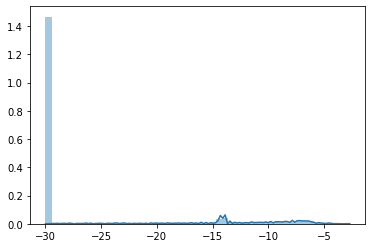

In [12]:
sns.distplot(y);

High Risk: 93
Low Risk: 8799
Percent High Risk: 1.0458839406207827


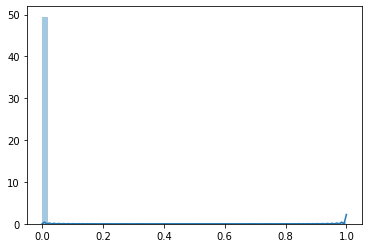

In [13]:
show_distrib(y, th=-6)

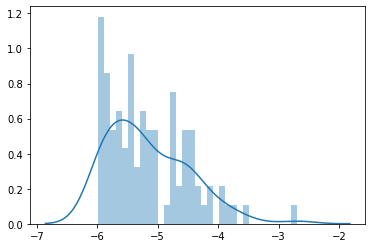

In [14]:
y_high_risk = y[np.where(y >= -6)]
sns.distplot(y_high_risk, bins=33);

### Get Train and Test data

In [15]:
# 1 -> high risk
# 0 -> low risk
y_risk_class = np.where(y >= -6, 1,0)
print(y_risk_class.shape)
y_risk_class

(8892, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_real, y_test_real = train_test_split(X, y, test_size=0.2, 
                                                                    random_state=42, 
                                                                    stratify=y_risk_class)
print(X_train.shape)
print(y_train_real.shape)
print(X_test.shape)
print(y_test_real.shape)

(7113, 75)
(7113, 1)
(1779, 75)
(1779, 1)


(7113, 1)
High Risk: 74
Low Risk: 7039
Percent High Risk: 1.0403486573878813


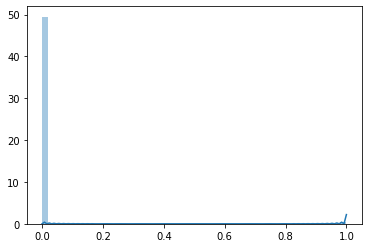

In [17]:
y_train = np.where(y_train_real >= -6, 1,0)
print(y_train.shape)
show_distrib(y_train, th=0.5)

(1779, 1)
High Risk: 19
Low Risk: 1760
Percent High Risk: 1.0680157391793141


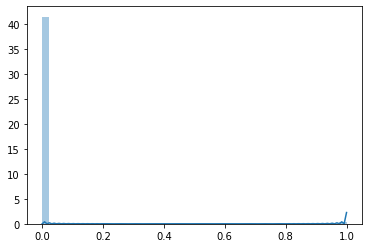

In [18]:
y_test = np.where(y_test_real >= -6, 1,0)
print(y_test.shape)
show_distrib(y_test, th=0.5)

### Over Sampling

In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train,y_train.reshape(-1,))
y_train = y_train.reshape(-1, 1)
print(X_train.shape)
print(y_train.shape)

(14078, 75)
(14078, 1)


High Risk: 7039
Low Risk: 7039
Percent High Risk: 50.0


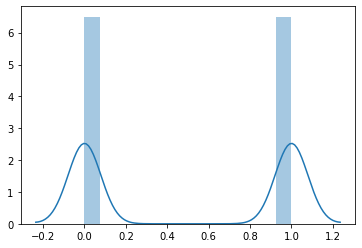

In [20]:
show_distrib(y_train, th=0.5)

High Risk: 19
Low Risk: 1760
Percent High Risk: 1.0680157391793141


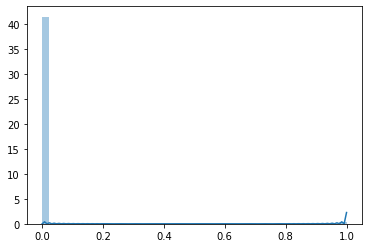

In [21]:
show_distrib(y_test, th=0.5)

### Scaling

In [23]:
# Scalers
X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

In [24]:
# Scaling X_train
X_train_scaled = X_train_scaler.fit_transform(X_train)
print(X_train_scaled.shape)
X_train_scaled

(14078, 75)


array([[4.33493700e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.66666667e-01],
       [2.73382860e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 9.04761905e-01],
       [4.74618626e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.57142857e-01],
       ...,
       [6.45422572e-02, 0.00000000e+00, 3.65969607e-01, ...,
        0.00000000e+00, 0.00000000e+00, 3.43880158e-01],
       [5.20460291e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.46409954e-01],
       [1.38666206e-02, 0.00000000e+00, 7.38873153e-01, ...,
        0.00000000e+00, 2.61126847e-01, 5.46559348e-01]])

In [25]:
# Scaling X_test
X_test_scaled = X_test_scaler.fit_transform(X_test)
print(X_test_scaled.shape)
X_test_scaled

(1779, 75)


array([[0.01256515, 0.        , 0.        , ..., 0.        , 0.        ,
        0.85714286],
       [0.02735843, 0.        , 0.        , ..., 0.        , 0.        ,
        0.71428571],
       [0.66493601, 0.        , 0.        , ..., 0.        , 1.        ,
        0.33333333],
       ...,
       [0.1255491 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.28571429],
       [0.90926743, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01492111, 0.        , 1.        , ..., 0.        , 0.        ,
        0.9047619 ]])

### Neural Network model

In [26]:
import tensorflow as tf
from tensorflow.keras import Model, optimizers, losses, regularizers
from tensorflow.keras.layers import Input, Dense

In [27]:
# Model
input_shape = X_train_scaled.shape[1]
inputs_1 = Input(shape=(input_shape))
dense_1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs_1)
dense_2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense_1)
dense_3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense_2)
dense_4 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense_3)
dense_5 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense_4)
dense_6 = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense_5)
output_1 = Dense(1, activation = 'sigmoid')(dense_6)

model_ffn = Model(inputs=inputs_1, outputs = output_1)

opt = optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss_ = losses.binary_crossentropy

model_ffn.compile(optimizer=opt,loss = loss_, metrics =['accuracy'])
print(model_ffn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               9728      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136   

In [28]:
class_weight = {0: 0.09,
                1: 1}

In [29]:
# Train
batch_size = 64
epochs = 350
model_ffn.fit(X_train_scaled, y_train, shuffle=True, 
              batch_size=batch_size, epochs=epochs, 
              class_weight=class_weight)

Train on 14078 samples
Epoch 1/350
14078/14078 [==============================] - 2s 168us/sample - loss: 0.2125 - accuracy: 0.7592
Epoch 2/350
14078/14078 [==============================] - 1s 37us/sample - loss: 0.0922 - accuracy: 0.8886
Epoch 3/350
14078/14078 [==============================] - 0s 34us/sample - loss: 0.0747 - accuracy: 0.9018
Epoch 4/350
14078/14078 [==============================] - 0s 34us/sample - loss: 0.0670 - accuracy: 0.9091
Epoch 5/350
14078/14078 [==============================] - 0s 34us/sample - loss: 0.0617 - accuracy: 0.9154
Epoch 6/350
14078/14078 [==============================] - 1s 40us/sample - loss: 0.0553 - accuracy: 0.9292
Epoch 7/350
14078/14078 [==============================] - 1s 59us/sample - loss: 0.0597 - accuracy: 0.9169
Epoch 8/350
14078/14078 [==============================] - 1s 42us/sample - loss: 0.0504 - accuracy: 0.9368
Epoch 9/350
14078/14078 [==============================] - 0s 35us/sample - loss: 0.0453 - accuracy: 0.9470
Epoc

14078/14078 [==============================] - 0s 29us/sample - loss: 0.0211 - accuracy: 0.9821
Epoch 77/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0192 - accuracy: 0.9853
Epoch 78/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0187 - accuracy: 0.9869
Epoch 79/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0201 - accuracy: 0.9847
Epoch 80/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0225 - accuracy: 0.9787
Epoch 81/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0190 - accuracy: 0.9866
Epoch 82/350
14078/14078 [==============================] - 1s 52us/sample - loss: 0.0232 - accuracy: 0.9776
Epoch 83/350
14078/14078 [==============================] - 0s 34us/sample - loss: 0.0186 - accuracy: 0.9881
Epoch 84/350
14078/14078 [==============================] - 0s 31us/sample - loss: 0.0189 - accuracy: 0.9871
Epoch 85/350
14078/14078 [======

14078/14078 [==============================] - 0s 29us/sample - loss: 0.0233 - accuracy: 0.9729
Epoch 151/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0210 - accuracy: 0.9788
Epoch 152/350
14078/14078 [==============================] - 0s 30us/sample - loss: 0.0213 - accuracy: 0.9782
Epoch 153/350
14078/14078 [==============================] - 0s 32us/sample - loss: 0.0208 - accuracy: 0.9793
Epoch 154/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0212 - accuracy: 0.9788
Epoch 155/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0221 - accuracy: 0.9768s - loss: 0.0241 - accura
Epoch 156/350
14078/14078 [==============================] - 1s 36us/sample - loss: 0.0202 - accuracy: 0.9805
Epoch 157/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0199 - accuracy: 0.9807
Epoch 158/350
14078/14078 [==============================] - 0s 27us/sample - loss: 0.0199 - accuracy: 0.9810

14078/14078 [==============================] - 0s 28us/sample - loss: 0.0483 - accuracy: 0.9295
Epoch 225/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0474 - accuracy: 0.9304
Epoch 226/350
14078/14078 [==============================] - 0s 31us/sample - loss: 0.0464 - accuracy: 0.9315
Epoch 227/350
14078/14078 [==============================] - 0s 30us/sample - loss: 0.0456 - accuracy: 0.9337
Epoch 228/350
14078/14078 [==============================] - 0s 27us/sample - loss: 0.0452 - accuracy: 0.9332
Epoch 229/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0444 - accuracy: 0.9346
Epoch 230/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0439 - accuracy: 0.9349
Epoch 231/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0438 - accuracy: 0.9337
Epoch 232/350
14078/14078 [==============================] - 0s 31us/sample - loss: 0.0430 - accuracy: 0.9359
Epoch 233/350
14078/1407

14078/14078 [==============================] - 0s 29us/sample - loss: 0.0253 - accuracy: 0.9680
Epoch 299/350
14078/14078 [==============================] - 0s 32us/sample - loss: 0.0249 - accuracy: 0.9697
Epoch 300/350
14078/14078 [==============================] - 0s 30us/sample - loss: 0.0310 - accuracy: 0.9566
Epoch 301/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0253 - accuracy: 0.9685
Epoch 302/350
14078/14078 [==============================] - 0s 30us/sample - loss: 0.0250 - accuracy: 0.9690
Epoch 303/350
14078/14078 [==============================] - 0s 31us/sample - loss: 0.0248 - accuracy: 0.9695
Epoch 304/350
14078/14078 [==============================] - 0s 29us/sample - loss: 0.0261 - accuracy: 0.9670
Epoch 305/350
14078/14078 [==============================] - 0s 28us/sample - loss: 0.0243 - accuracy: 0.9710
Epoch 306/350
14078/14078 [==============================] - 0s 32us/sample - loss: 0.0244 - accuracy: 0.9706
Epoch 307/350
14078/1407

In [30]:
# Predict
predictions = model_ffn.predict(X_test_scaled)
predictions

array([[0.        ],
       [0.        ],
       [0.08707783],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]], dtype=float32)

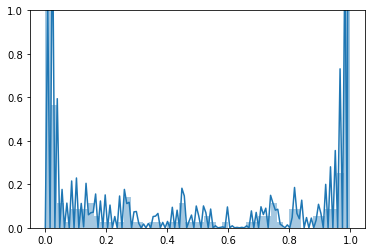

In [31]:
sns.distplot(predictions)
plt.ylim(0,1)
plt.show()

High Risk: 108
Low Risk: 1671
Percent High Risk: 6.070826306913997


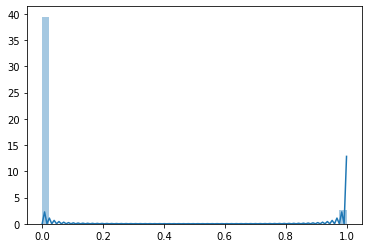

In [32]:
show_distrib(predictions, th=0.5)

In [33]:
'''import catboost
model_ml = catboost.CatBoostClassifier(verbose=False)
model_ml.fit(X_train_scaled, y_train)
predictions_ = model_ml.predict(X_test_scaled)
predictions_ = predictions_.reshape(-1, 1)
print(np.sum(predictions_==1))'''

'import catboost\nmodel_ml = catboost.CatBoostClassifier(verbose=False)\nmodel_ml.fit(X_train_scaled, y_train)\npredictions_ = model_ml.predict(X_test_scaled)\npredictions_ = predictions_.reshape(-1, 1)\nprint(np.sum(predictions_==1))'

In [34]:
threshold = 0.4

In [35]:
predictions_real = np.where(predictions >= threshold, -5, -6.00001)
print(predictions_real.shape)
predictions_real

(1779, 1)


array([[-6.00001],
       [-6.00001],
       [-6.00001],
       ...,
       [-6.00001],
       [-6.00001],
       [-6.00001]])

In [36]:
predictions_classif = np.where(predictions >= threshold, 1, 0)
print(predictions_classif.shape)
predictions_classif

(1779, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [37]:
'''predictions_ = np.asarray(X_test["risk"])
predictions_ = predictions_.reshape(-1, 1)
predictions_.shape'''

'predictions_ = np.asarray(X_test["risk"])\npredictions_ = predictions_.reshape(-1, 1)\npredictions_.shape'

Classification Report
              precision    recall  f1-score   support

    Low_Risk       1.00      0.94      0.97      1760
   High_Risk       0.10      0.63      0.18        19

    accuracy                           0.94      1779
   macro avg       0.55      0.79      0.57      1779
weighted avg       0.99      0.94      0.96      1779

Balanced Accuracy: 0.786
f1 score (macro avg): 0.573
Confusion matrix
[[1656  104]
 [   7   12]]


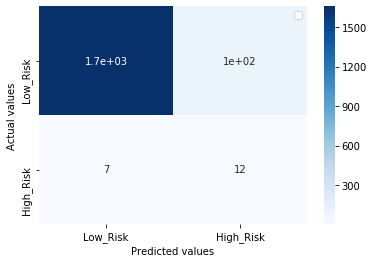

In [38]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score, auc, roc_curve, balanced_accuracy_score

y_pred = predictions_classif
y = y_test

target_names = ['Low_Risk', 'High_Risk']
print('Classification Report')
print(classification_report(y, y_pred, target_names=target_names))
print('Balanced Accuracy: %.3f' % balanced_accuracy_score(y, y_pred))
print('f1 score (macro avg): %.3f' % f1_score(y, y_pred, average='macro'))
print('Confusion matrix')
cm = confusion_matrix(y, y_pred)
print(cm)
cmap = plt.cm.Blues
plt.legend(target_names)
hm = sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=target_names, yticklabels=target_names)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel("Predicted values")
plt.ylabel("Actual values")
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, fbeta_score

'''
predicted = np.zeros(y_test.shape[0])
predicted.fill(-5)
predicted = predicted.reshape(-1, 1)
'''

predicted = predictions_real
real = y_test_real

real_binary = []
predicted_binary = []

for a in list(real):
    if (a >= -6):
        real_binary.append(1)
    else:
        real_binary.append(0)
        
for a in list(predicted):
    if (a >= -6):
        predicted_binary.append(1)
    else:
        predicted_binary.append(0)

fscore = fbeta_score(real_binary, predicted_binary, 2)
print(f"F_score = {fscore}")
real_mse = real[np.where(real >= -6)]
predicted_mse = predicted[np.where(real >= -6)]

mse = mean_squared_error(real_mse, predicted_mse)
print(f"MSE = {mse}")

score = mse/fscore
print(f"F_Beta Score (Beta=2): {score}")

F_score = 0.3125
MSE = 0.8148479414441696
F_Beta Score (Beta=2): 2.607513412621343


### Submission

In [40]:
df_test = pd.read_csv("test_data.csv")
#Dropping first the empty column 
df_test = df_test.drop("c_rcs_estimate", axis=1)

#OHE for c_object_type (5 categories) -> 5 new features
df_test = pd.get_dummies(df_test)

#Binary encoder for mission_id (19 categories) -> 5 new features
encoder = BinaryEncoder(cols=['mission_id'], drop_invariant=True)
df_test = encoder.fit_transform(df_test)

# Event Lenght column
df_test["event-lenght"] = df_test.groupby('event_id')['event_id'].transform('value_counts')

# Getting X_test
X_test = df_test.sort_values('time_to_tca',ascending=False).groupby('event_id').tail(1)
X_test = X_test.sort_values('event_id')

# First Approach: Drop all columns with any NaN value
X_test = X_test.dropna(axis=1, how='any')

# Set event_id as index
X_test.set_index("event_id", inplace=True)

X_test

,time_to_tca,mission_id_1,mission_id_2,mission_id_3,mission_id_4,mission_id_5,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,c_object_type_DEBRIS,c_object_type_PAYLOAD,c_object_type_ROCKET BODY,c_object_type_TBA,c_object_type_UNKNOWN,event-lenght
event_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.228761,0,0,0,0,1,-7.332267,-7.227312,1.863127,32792.0,7929.0,-375.6,27793.8,17399.4,-27.1,-4207.7,6720.9,1.0,0.0,6.62,6.62,242,241,99.5,1.075,0.012410,0.020745,0.000014,7084.699726,0.003744,98.218015,-0.651483,-0.356146,0.292950,180.0,2.0,29.45,29.44,18.0,17.0,83.3,4.113,0.308274,0.106612,0.000379,7082.277004,0.004097,74.114496,-0.014579,-0.589305,0.062886,1.50,2.0,733.086815,680.038638,733.155531,675.124476,-66.166942,57.950882,0.195817,260.590619,1.148942e+06,4.858775e+16,5.833502,212.798144,62.328701,28349.650792,4.173933,45.332924,0,0,0,0,1,5
1,2.129518,0,0,0,1,0,-7.933674,-5.528562,8.701856,935.0,63.0,478.6,-779.0,196.9,-53.4,-27.6,20.9,1.0,0.0,6.61,6.61,207,207,99.4,0.997,0.018384,0.011079,0.000012,7170.601850,0.000739,98.706633,0.207413,0.297498,0.051009,1.0,0.0,14.48,14.48,26.0,24.0,98.6,1.029,0.345921,0.217909,0.000296,7119.515214,0.010989,98.756419,-0.040085,0.592206,0.101123,4.12,2.0,797.765439,787.164261,819.616171,663.140258,70.513190,37.134694,57.043790,5.070173,1.589709e+06,1.887353e+13,7.668534,95.178865,42.408877,815.099642,4.151353,70.402924,0,0,0,0,1,2
2,2.287244,0,0,0,1,1,-30.000000,-5.841035,389.260270,30488.0,9279.0,-325.8,-23962.4,-18848.1,33.2,-5737.5,7293.6,1.0,0.0,4.04,4.05,455,455,99.2,1.264,0.020731,0.014828,0.000015,7062.079675,0.000549,98.184153,-0.087434,-0.016364,0.037929,1.0,0.0,6.42,6.43,36.0,36.0,99.3,2.021,1.972867,0.277907,0.001536,7055.259147,0.001632,98.268723,-0.589164,0.093741,-0.010029,21.00,2.0,687.821934,680.063416,688.635518,665.608776,79.541510,51.809691,-0.204983,395.819448,1.423435e+04,3.920972e+11,1.509891,23.247498,47.704255,2917.758473,1.664111,11.493593,0,0,0,0,1,15
3,2.103093,0,0,1,0,0,-30.000000,-6.890421,139.385422,12287.0,10503.0,1115.7,-8708.5,-8596.3,43.0,-7374.6,7479.1,1.0,0.0,3.46,3.46,2751,2751,99.3,1.080,0.007600,0.001413,0.000007,7084.771599,0.001248,91.939061,0.041378,-0.467537,-0.062065,1.0,0.0,32.01,32.01,19.0,18.0,100.0,2.392,0.605262,0.134430,0.000677,7059.437452,0.005757,98.958313,0.237534,-0.539320,-0.309534,5.10,2.0,715.476875,697.792323,721.941904,640.659000,80.940732,45.403085,-0.234562,74.421941,1.459433e+04,4.975731e+14,3.918112,95.736033,23.986840,1913.582765,1.457081,152.653431,0,0,0,0,1,15
4,2.083777,0,0,1,0,1,-30.000000,-7.389872,314.832717,22356.0,14323.0,136.6,6959.3,21245.7,9.4,-13612.5,4458.3,1.0,0.0,3.72,3.72,470,469,98.4,1.166,0.012294,0.001961,0.000040,6995.837900,0.002967,97.842828,-0.128809,0.175205,-0.019724,1.0,0.0,6.42,6.42,42.0,42.0,99.3,1.314,0.826453,0.473670,0.001537,7031.066828,0.003030,86.325671,-0.300691,-0.117041,-0.031371,1.00,2.0,638.456229,596.945571,674.236963,631.622694,80.776288,18.134405,-0.037600,559.457161,5.833318e+04,3.449952e+12,3.769634,30.660987,56.631034,3556.931262,1.158802,18.025759,1,0,0,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [41]:
# Scaling
X_test_scaler = MinMaxScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

In [42]:
predictions = model_ffn.predict(X_test_scaled)
predictions_real = np.where(predictions >= 0.5, -5, -6.00001)

In [43]:
predictions_real = X_test["risk"].values.reshape(-1, 1)
predictions_real[predictions_real >= -6] = -5
predictions_real[predictions_real < -6] = -6.0001
predictions_real.shape

(2167, 1)

In [44]:
# Create predictions array with event_id's
ids = np.arange(0,predictions_real.shape[0]).reshape(-1, 1)
y_test = np.concatenate((ids,predictions_real), axis=1)
print(y_test.shape)
y_test

(2167, 2)


array([[ 0.0000e+00, -6.0001e+00],
       [ 1.0000e+00, -6.0001e+00],
       [ 2.0000e+00, -6.0001e+00],
       ...,
       [ 2.1640e+03, -6.0001e+00],
       [ 2.1650e+03, -6.0001e+00],
       [ 2.1660e+03, -6.0001e+00]])

In [45]:
#df_submission = pd.DataFrame(y_test,columns={"event_id","predicted_risk"})
#df_submission.to_csv("submision_aaa333.csv", sep=",", index=False)